##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gaussian Process Regression in TensorFlow Probability 


In this tutorial, we explore Gaussian process regression using
TensorFlow 2.0 and TensorFlow Probability. We generate some noisy observations from
some known functions and fit GP models to those data. We will then sample from the GP
posterior and plot the sampled function values over grids in their domains. This tutorial will also cover Markov Chain Monte Carlo methods and Deep Gaussian Processes. 

The following tutorial's adapted from the original Tensorflow 1.0 tutorial for Gaussian Process Regression (https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb)


## Background
Let $\mathcal{X}$ be any set. A *Gaussian process*
(GP) is a collection of random variables indexed by $\mathcal{X}$ such that if
$\{X_1, \ldots, X_n\} \subset \mathcal{X}$ is any finite subset, the marginal density
$p(X_1 = x_1, \ldots, X_n = x_n)$ is multivariate Gaussian. Any Gaussian
distribution is completely specified by its first and second central moments
(mean and covariance), and GP's are no exception. We can specify a GP completely
in terms of its mean function $\mu : \mathcal{X} \to \mathbb{R}$ and covariance function
$k : \mathcal{X} \times \mathcal{X} \to \mathbb{R}$. Most of the expressive power of GP's is encapsulated
in the choice of covariance function. For various reasons, the covariance
function is also referred to as a *kernel function*. It is required only to be
symmetric and positive-definite (see [Ch. 4 of Rasmussen & Williams](
http://www.gaussianprocess.org/gpml/chapters/RW4.pdf)). 

A full sample from a GP comprises a real-valued function over the entire space
$\mathcal{X}$ and is in practice impractical to realize; often one chooses a set of
points at which to observe a sample and draws function values at these points.
This is achieved by sampling from an appropriate (finite-dimensional)
multi-variate Gaussian.

Note that, according to the above definition, any finite-dimensional
multivariate Gaussian distribution is also a Gaussian process. Usually, when
one refers to a GP, it is implicit that the index set is some $\mathbb{R}^n$
and we will indeed make this assumption here.

A common application of Gaussian processes in machine learning is Gaussian
process regression. The idea is that we wish to estimate an unknown function
given noisy observations $\{y_1, \ldots, y_N\}$ of the function at a finite
number of points $\{x_1, \ldots x_N\}.$ We imagine a generative process

$$
\begin{align}
f \sim \: & \textsf{GaussianProcess}\left(
    \text{mean_fn}=\mu(x),
    \text{covariance_fn}=k(x, x')\right) \\
y_i \sim \: & \textsf{Normal}\left(
    \text{loc}=f(x_i),
    \text{scale}=\sigma\right), i = 1, \ldots, N
\end{align}
$$

As noted above, the sampled function is impossible to compute, since we would
require its value at an infinite number of points. Instead, one considers a
finite sample from a multivariate Gaussian.

$$
  \begin{gather}
    \begin{bmatrix}
      f(x_1) \\
      \vdots \\
      f(x_N)
    \end{bmatrix}
    \sim
    \textsf{MultivariateNormal} \left( \:
      \text{loc}=
      \begin{bmatrix}
        \mu(x_1) \\
        \vdots \\
        \mu(x_N)
      \end{bmatrix} \:,\:
      \text{scale}=
      \begin{bmatrix}
        k(x_1, x_1) & \cdots & k(x_1, x_N) \\
        \vdots & \ddots & \vdots \\
        k(x_N, x_1) & \cdots & k(x_N, x_N) \\
      \end{bmatrix}^{1/2}
    \: \right)
  \end{gather} \\
  y_i \sim \textsf{Normal} \left(
      \text{loc}=f(x_i),
      \text{scale}=\sigma
  \right)
$$

Note the exponent $\frac{1}{2}$ on the covariance matrix: this denotes a
Cholesky decomposition. Comptuing the Cholesky is necessary because the MVN is
a location-scale family distribution. Unfortunately the Cholesky decomposition
is computationally expensive, taking $O(N^3)$ time and $O(N^2)$ space. Much of
the GP literature is focused on dealing with this seemingly innocuous little
exponent.

It is common to take the prior mean function to be constant, often zero. Also,
some notational conventions are convenient. One often writes $\mathbf{f}$ for the
finite vector of sampled function values. A number of interesting notations are
used for the covariance matrix resulting from the application of $k$ to pairs of
inputs. Following [(Quiñonero-Candela, 2005)][QuinoneroCandela2005], we note
that the components of the matrix are covariances of function values at
particular input points. Thus we can denote the covariance matrix as $K_{AB}$
where $A$ and $B$ are some indicators of the collection of function values along
the given matrix dimensions.

[QuinoneroCandela2005]: http://www.jmlr.org/papers/volume6/quinonero-candela05a/quinonero-candela05a.pdf

For example, given observed data $(\mathbf{x}, \mathbf{y})$ with implied latent function
values $\mathbf{f}$, we can write

$$
K_{\mathbf{f},\mathbf{f}} = \begin{bmatrix}
  k(x_1, x_1) & \cdots & k(x_1, x_N) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x_1) & \cdots & k(x_N, x_N) \\
\end{bmatrix}
$$

Similarly, we can mix sets of inputs, as in

$$
K_{\mathbf{f},*} = \begin{bmatrix}
  k(x_1, x^*_1) & \cdots & k(x_1, x^*_T) \\
  \vdots & \ddots & \vdots \\
  k(x_N, x^*_1) & \cdots & k(x_N, x^*_T) \\
\end{bmatrix}
$$

where we suppose there are $N$ training inputs, and $T$ test inputs. The above
generative process may then be written compactly as

$$
\begin{align}
\mathbf{f} \sim \: & \textsf{MultivariateNormal} \left(
        \text{loc}=\mathbf{0},
        \text{scale}=K_{\mathbf{f},\mathbf{f}}^{1/2}
    \right) \\
y_i \sim \: & \textsf{Normal} \left(
    \text{loc}=f_i,
    \text{scale}=\sigma \right), i = 1, \ldots, N
\end{align}
$$

The sampling operation in the first line yields a finite set of $N$ function
values from a multivariate Gaussian -- *not an entire function as in the above
GP draw notation*. The second line describes a collection of $N$ draws from
*univariate* Gaussians centered at the various function values, with fixed
observation noise $\sigma^2$.

With the above generative model in place, we can proceed to consider the
posterior inference problem. This yields a posterior distribution over function
values at a new set of test points, conditioned on the observed noisy data from
the process above.

With the above notation in place, we can compactly write the posterior
predictive distribution over future (noisy) observations conditional on
corresponding inputs and training data as follows (for more details, see §2.2 of
[Rasmussen & Williams](http://www.gaussianprocess.org/gpml/)). 

$$
\mathbf{y}^* \mid \mathbf{x}^*, \mathbf{x}, \mathbf{y} \sim \textsf{Normal} \left(
    \text{loc}=\mathbf{\mu}^*,
    \text{scale}=(\Sigma^*)^{1/2}
\right),
$$

where

$$
\mathbf{\mu}^* = K_{*,\mathbf{f}}\left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} \mathbf{y}
$$

and

$$
\Sigma^* = K_{*,*} - K_{*,\mathbf{f}}
    \left(K_{\mathbf{f},\mathbf{f}} + \sigma^2 I \right)^{-1} K_{\mathbf{f},*}
$$

## Imports

In [0]:
!pip install tensorflow==2.0.0
!pip install tfp-nightly
!pip install gast==0.2.2

In [18]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk
import matplotlib.pyplot as plt

print(tf.__version__)
print(tfp.__version__)

2.0.0
0.9.0-dev20191013


## Example: Exact GP Regression on Noisy Sinusoidal Data
Here we generate training data from a noisy sinusoid, then sample a bunch of
curves from the posterior of the GP regression model. We use
[Adam](https://arxiv.org/abs/1412.6980) to optimize the kernel hyperparameters
(we minimize the negative log likelihood of the data under the prior). We
plot the training curve, followed by the true function and the posterior
samples.

In [0]:
def sinusoid(x):
  return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
  """Generate noisy sinusoidal observations at a random set of points.

  Returns:
     observation_index_points, observations
  """
  index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
  index_points_ = index_points_.astype(np.float64)

  observations_ = (sinusoid(index_points_) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
  return index_points_, observations_

In [0]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=.1)

Below we make use of the
ExponentiatedQuadratic covariance kernel. Its form is

$$
k(x, x') := \sigma^2 \exp \left( \frac{\|x - x'\|^2}{\lambda^2} \right)
$$

where $\sigma^2$ is called the 'amplitude' and $\lambda$ the *length scale*.
We will now define these kernel parameters and optimise them via a maximum likelihood procedure.

In [0]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
amplitude_ = tf.Variable(initial_value=1., name='amplitude_', dtype=np.float64)
length_scale_ = tf.Variable(initial_value=1., name='length_scale_', dtype=np.float64)
observation_noise_variance_ = tf.Variable(initial_value=1e-6,
                                         name='observation_noise_variance_',
                                         dtype=np.float64)

We will now define the marginal likelihood $p(y | X, \theta)$ of the GP distribution. By maximizing it based on our observed data $(X, y)$, we can find the optimal hyperparameters $\hat\theta$ of our GP model. The optimal hyperparameter is defined as follows:

$$\hat\theta = \underset{\theta}{\arg\max}(p(y | X, \theta))$$

The marginal likelihood of the GP is the likelihood of a multivariate Gaussian distribution which is given as:

$$p(y | \mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}} \exp(-\frac{1}{2}(y-\mu)^{\top}\Sigma^{-1}(y-\mu)) $$

In our case, $\mu$ and $\Sigma$ are defined by the mean function $m_{\theta}(x)$ and the covariance (kernel) function $k_{\theta}(x,x')$ of our GP model. Therefore, the likelihood could be re-written as:

$$p(y | \mu, \theta) = \frac{1}{\sqrt{(2\pi)^d|\Sigma_{\theta}|}} \exp(-\frac{1}{2}(y-\mu_{\theta})^{\top}\Sigma_{\theta}^{-1}(y-\mu_{\theta})) $$

where $d$ is the dimensionality of the marginal and $|\Sigma_{\theta}|$ is the determinant of the covariance kernel. Now let's get rid of the exponent on the right hand side by taking the log on both sides. 

$$\log p(y | X, \theta) = -\frac{1}{2}(y - \mu_{\theta})^{\top} \Sigma_{\theta}^{-1} (y - \mu_{\theta}) - \frac{1}{2} \log |\Sigma_{\theta}| - \frac{d}{2}\log 2\pi$$

The optimal hyperparameter $\hat\theta$ can therefore be found by minimizing the negative log marginal likelihood:

$$\hat\theta = \underset{\theta}{\arg\max}(p(y | X, \theta)) = \underset{\theta}{\arg\min}\log p(y | X, \theta)$$

*Note that the function neg_log_likelihood is decorated with @tf.function. This allows us to compile our function into a high performance Tensorflow graph, giving us the benefit of faster execution while still using natural Python syntax*

In [0]:
@tf.function #  <- faster execution 
def neg_log_likelihood():
    amplitude = np.finfo(np.float64).tiny + tf.nn.softplus(amplitude_)
    length_scale = np.finfo(np.float64).tiny + tf.nn.softplus(length_scale_)
    observation_noise_variance = np.finfo(np.float64).tiny + tf.nn.softplus(observation_noise_variance_)

    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    gp = tfd.GaussianProcess(
        kernel=kernel,
        index_points=observation_index_points_,
        observation_noise_variance=observation_noise_variance
    )

    return -gp.log_prob(observations_)

The [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf) will be used to tune our hyperparameters.



In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

One of the key benefits of TF2.0 over TF1.0 is the use of eager execution by default. Eager Execution means tf.Tensor will work seamlessly with NumPy arrays and standard Python debugging tools can be used for immediate error reporting and inspection of results. 

Training and/or gradient computation in eager mode is done using tf.GradientTape. 

In [24]:
# Now we optimize the model parameters.
num_iters = 1000

#initialize negative log-likelihood as an array so that we can print out the training history for inspection later on 
nlls = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    nlls[i] = neg_log_likelihood()
    with tf.GradientTape() as tape:
        loss = neg_log_likelihood()
    grads = tape.gradient(loss, [amplitude_, length_scale_, observation_noise_variance_])
    optimizer.apply_gradients(zip(grads, [amplitude_, length_scale_, observation_noise_variance_]))

print('Trained parameters:'.format(amplitude_))
print('amplitude: {}'.format(amplitude_))
print('length_scale: {}'.format(length_scale_))
print('observation_noise_variance: {}'.format(observation_noise_variance_))

Trained parameters:
amplitude: <tf.Variable 'amplitude_:0' shape=() dtype=float64, numpy=0.45639892533824294>
length_scale: <tf.Variable 'length_scale_:0' shape=() dtype=float64, numpy=-1.6954129694299196>
observation_noise_variance: <tf.Variable 'observation_noise_variance_:0' shape=() dtype=float64, numpy=-2.2843646601887317>


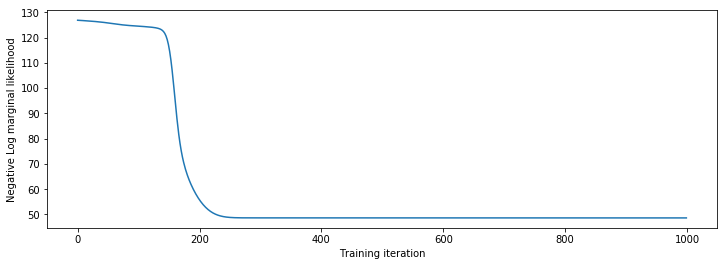

In [25]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(nlls)
plt.xlabel("Training iteration")
plt.ylabel("Negative Log marginal likelihood")
plt.show()

In [0]:
#let's re-define the kernel using the trained parameters

amplitude = np.finfo(np.float64).tiny + tf.nn.softplus(amplitude_)
length_scale = np.finfo(np.float64).tiny + tf.nn.softplus(length_scale_)
observation_noise_variance = np.finfo(np.float64).tiny + tf.nn.softplus(observation_noise_variance_)

kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

Using the trained hyperparameters, let's sample from the posterior distribution $p(y| X, \theta)$ conditioned on observations $X$ and hyperparameters $\theta$. We will draw samples at points other than the training inputs. 

In [0]:
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,  # Reuse the same kernel instance, with the same params
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance,
    predictive_noise_variance=0.)

#compute the mean and standard deviation of the predictions from the trained model
posterior_mean = gprm.mean()
posterior_std = gprm.stddev()

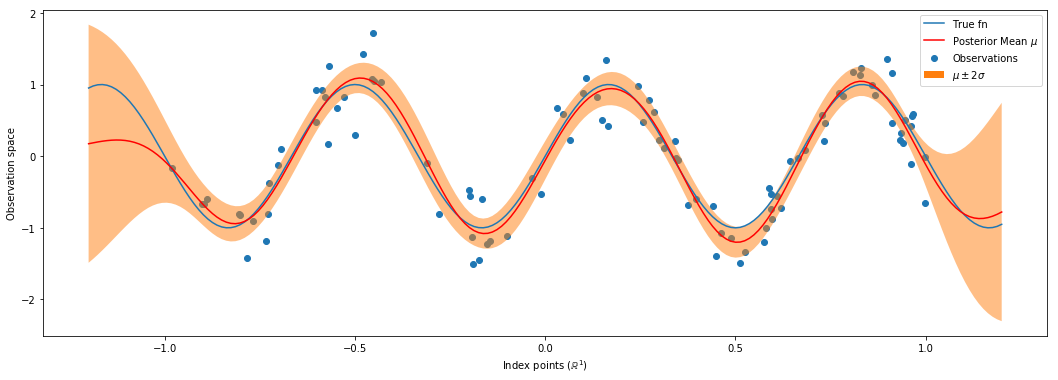

In [30]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(18, 6))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

plt.plot(predictive_index_points_, posterior_mean, c='r', label='Posterior Mean $\mu$')
plt.fill_between(predictive_index_points_[:,0],  posterior_mean - 2*posterior_std, posterior_mean + 2*posterior_std, alpha=.5, label='$\mu \pm 2\sigma$')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

*Note: if you run the above code several times, sometimes it looks great and
other times it looks terrible! The maximum likelihood training of the parameters
is quite sensitive and sometimes converges to poor models. The best approach
is to use MCMC to marginalize the model hyperparameters.*

## Marginalisation of model hyperparameters using Markov-Chain Monte Carlo

Here we use Tensorflow Probability's MCMC functionality to marginalise GP hyperparameters (kernel parameters & observation noise variance).

### What is Markov-Chain Monte Carlo? ###

Markov-Chain Monte Carlo (MCMC) techniques are methods for sampling from probability distributions using Markov chains. 

To understand what Monte Carlo and Markov Chain are, let's take a distribution $p(x)$ and compute its expectation $E[x]$. The expectation is given as:

$$ 

/usr/local/lib/python2.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


Acceptance rate: 0.84


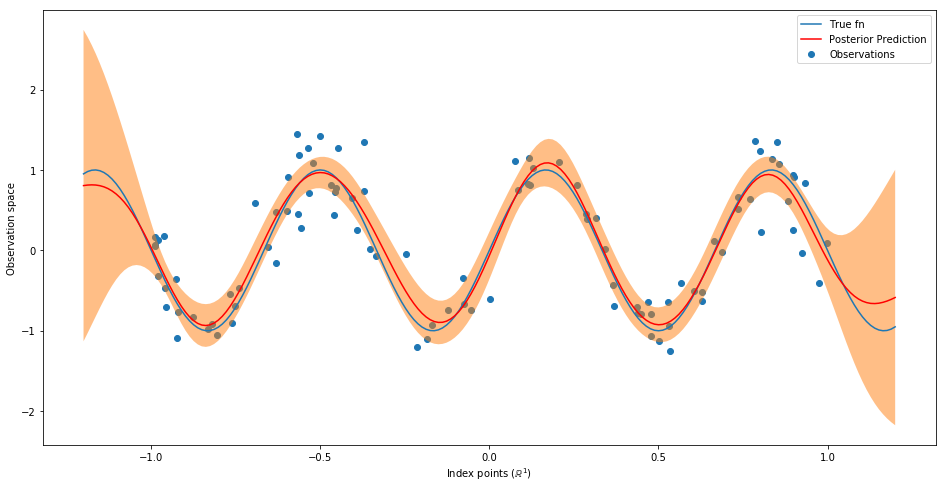

In [0]:
def joint_log_prob(
    index_points, observations, amplitude, length_scale, noise_variance):

  # Hyperparameter Distributions.
  rv_amplitude = tfd.LogNormal(np.float64(0.), np.float64(1))
  rv_length_scale = tfd.LogNormal(np.float64(0.), np.float64(1))
  rv_noise_variance = tfd.LogNormal(np.float64(0.), np.float64(1))

  gp = tfd.GaussianProcess(
      kernel=tfk.ExponentiatedQuadratic(amplitude, length_scale),
      index_points=index_points,
      observation_noise_variance=noise_variance)

  return (
      rv_amplitude.log_prob(amplitude) +
      rv_length_scale.log_prob(length_scale) +
      rv_noise_variance.log_prob(noise_variance) +
      gp.log_prob(observations)
  )

# Construct a chain of hyperparameter variables that we want to optimise
initial_chain_states = [
    1e-1 * tf.ones([], dtype=np.float64, name='init_amplitude'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_length_scale'),
    1e-1 * tf.ones([], dtype=np.float64, name='init_obs_noise_variance')
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
]

def unnormalized_log_posterior(amplitude, length_scale, noise_variance):
  return joint_log_prob(
      observation_index_points_, observations_, amplitude, length_scale,
      noise_variance)

num_results = 200

@tf.function   # <- make things fast
def run_mcmc():
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=500,
    num_steps_between_results=3,
    current_state=initial_chain_states,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            step_size=[np.float64(.15)],
            num_leapfrog_steps=3),
        bijector=unconstraining_bijectors))
  
[amplitudes,length_scales,observation_noise_variances], kernel_results = run_mcmc()

# Now we can sample from the posterior predictive distribution at a new set
# of index points.
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

gprm = tfd.GaussianProcessRegressionModel(
    kernel=tfk.ExponentiatedQuadratic(amplitudes, length_scales),
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variances,
    predictive_noise_variance=0.)

samples = np.transpose(gprm.sample())

posterior_mean = np.mean(samples, axis=1)
posterior_std = np.std(samples, axis=1)

print("Acceptance rate: {}".format(
    np.mean(kernel_results.inner_results.is_accepted)))

# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(16, 8))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

plt.plot(predictive_index_points_, posterior_mean, c='r', label='Posterior Prediction')
plt.fill_between(predictive_index_points_[:,0],  posterior_mean - 2*posterior_std, posterior_mean + 2*posterior_std, alpha=.5)

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## GP and Deep GP using Keras Functional API

Using Keras functional API, we can easily construct and train a GP and Deep Gaussian Process model. 


In [0]:
np.random.seed(43)
dtype = np.float64

n = 1000
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def s(x):
  g = (x - x_range[0]) / (x_range[1] - x_range[0])
  return 3*(0.25 + g**2.)

x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
eps = np.random.randn(n) * s(x)
y = (w0 * x * (1 + np.sin(x)) + b0) + eps
x0 = np.linspace(*x_range, num=1000)

class KernelFn(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(KernelFn, self).__init__(**kwargs)

    self._amplitude = self.add_variable(
        initializer=tf.constant_initializer(.54),
        dtype=dtype,
        name='amplitude')

  def call(self, x):
    return x

  @property
  def kernel(self):
    return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
        amplitude=tf.nn.softplus(self._amplitude))

num_inducing_points = 50

# Add a leading dimension for the event_shape.
eyes = np.expand_dims(np.eye(num_inducing_points), 0)
variational_inducing_observations_scale_initializer = (
    tf.constant_initializer(1e-3 * eyes))

gp = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=dtype),
    tf.keras.layers.Dense(1, kernel_initializer='Ones', use_bias=False, activation=None, dtype=dtype),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=KernelFn(dtype=dtype),
        inducing_index_points_initializer=(
            tf.constant_initializer(
                np.linspace(*x_range,
                            num=num_inducing_points,
                            dtype=dtype)[..., np.newaxis])),
        variational_inducing_observations_scale_initializer=(
            variational_inducing_observations_scale_initializer))
])

deep_gp = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=dtype),
    tf.keras.layers.Dense(1, kernel_initializer='Ones', use_bias=False, activation=None, dtype=dtype),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=KernelFn(dtype=dtype),
        inducing_index_points_initializer=(
            tf.constant_initializer(
                np.linspace(*x_range,
                            num=num_inducing_points,
                            dtype=dtype)[..., np.newaxis])),
        variational_inducing_observations_scale_initializer=(
            variational_inducing_observations_scale_initializer)),
    tfp.layers.VariationalGaussianProcess(
            num_inducing_points=num_inducing_points,
            kernel_provider=KernelFn(dtype=dtype),
            inducing_index_points_initializer=(
                tf.constant_initializer(
                    np.linspace(*x_range,
                                num=num_inducing_points,
                                dtype=dtype)[..., np.newaxis])),
            variational_inducing_observations_scale_initializer=(
                variational_inducing_observations_scale_initializer)),
    tfp.layers.VariationalGaussianProcess(
            num_inducing_points=num_inducing_points,
            kernel_provider=KernelFn(dtype=dtype),
            inducing_index_points_initializer=(
                tf.constant_initializer(
                    np.linspace(*x_range,
                                num=num_inducing_points,
                                dtype=dtype)[..., np.newaxis])),
            variational_inducing_observations_scale_initializer=(
                variational_inducing_observations_scale_initializer))
])

batch_size = 64
kl_weight = np.float64(batch_size) 
loss = lambda y, d: d.variational_loss(y, kl_weight=kl_weight/n)
gp.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=loss)
gp.summary()

history = gp.fit(x, y, epochs=1000, batch_size=batch_size, verbose=False)

deep_gp.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=loss)
deep_gp.summary()

history_2 = deep_gp.fit(x, y, epochs=1000, batch_size=batch_size, verbose=False)

num_samples = 100

vgp = gp(x0[..., None])
deep_vgp = deep_gp(x0[..., None])
gp_samples = vgp.sample(num_samples)
deepgp_samples = deep_vgp.sample(num_samples)

W1013 13:46:36.883629 140176516200320 deprecation.py:323] From <ipython-input-14-c80b3fe3c628>:25: add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 1         
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    2603      
Total params: 2,604
Trainable params: 2,604
Non-trainable params: 0
_________________________________________________________________


W1013 13:46:39.566502 140176516200320 optimizer_v2.py:1029] Gradients do not exist for variables ['variational_gaussian_process/observation_noise_variance:0'] when minimizing the loss.
W1013 13:46:40.695305 140176516200320 optimizer_v2.py:1029] Gradients do not exist for variables ['variational_gaussian_process/observation_noise_variance:0'] when minimizing the loss.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 1         
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    2603      
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    2603      
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    2603      
Total params: 7,810
Trainable params: 7,810
Non-trainable params: 0
_________________________________________________________________


W1013 13:47:32.806658 140176516200320 optimizer_v2.py:1029] Gradients do not exist for variables ['variational_gaussian_process_1/observation_noise_variance:0', 'variational_gaussian_process_2/observation_noise_variance:0', 'variational_gaussian_process_3/observation_noise_variance:0'] when minimizing the loss.
W1013 13:47:35.226635 140176516200320 optimizer_v2.py:1029] Gradients do not exist for variables ['variational_gaussian_process_1/observation_noise_variance:0', 'variational_gaussian_process_2/observation_noise_variance:0', 'variational_gaussian_process_3/observation_noise_variance:0'] when minimizing the loss.


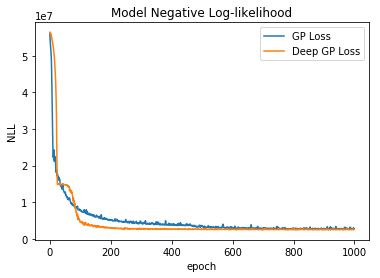

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
# summarize history for loss
plt.plot(history.history['loss'], label='GP Loss')
plt.plot(history_2.history['loss'], label='Deep GP Loss')
plt.title('Model Negative Log-likelihood')
plt.ylabel('NLL')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

print('GP Negative Log-likelihood: %d' %(gp.evaluate(x, y)))
print('Deep GP Negative Log-likelihood: %d' %(deep_gp.evaluate(x,y)))

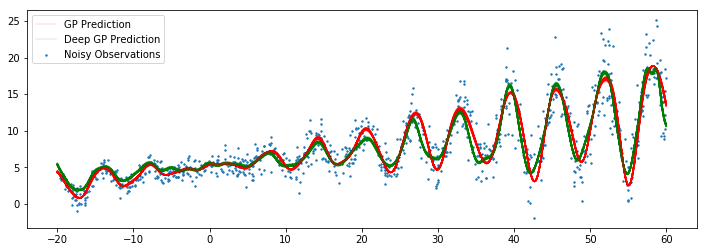

In [0]:
plt.figure(figsize=(12,4))
plt.scatter(x, y, s=2, label='Noisy Observations')

for i in range(num_samples):
  plt.plot(x0, gp_samples[i,:], c='r', alpha=.1, label = 'GP Prediction' if i == 0 else None)
  plt.plot(x0, deepgp_samples[i,:], c='g', alpha=.1, label = 'Deep GP Prediction' if i == 0 else None)

plt.legend()